# Cell Image Parasitized Torch CNN/AlexNet


In [1]:
import os
import random
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

In [2]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

# Train and Test Setting

In [3]:
train_ds=datasets.ImageFolder(root=("/kaggle/input/cell-images-parasitized-or-not/cell_images/train"),transform=transform)
test_ds=datasets.ImageFolder(root=("/kaggle/input/cell-images-parasitized-or-not/cell_images/train"),transform=transform)

In [4]:
class_names=train_ds.classes
print(class_names)
print(len(class_names))

['parasitized', 'uninfected']
2


torch.manual_seed(10)
test_size = len(dataset)//5
train_size = len(dataset) - test_size

train_ds, test_ds = random_split(dataset, [train_size, test_size])
len(train_ds), len(test_ds)   

In [5]:
train_loader=DataLoader(train_ds,batch_size=10,shuffle=True)
test_loader=DataLoader(test_ds,batch_size=10)

# Check Images and Labels

In [6]:
for images, labels in train_loader:
    break
#print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im=make_grid(images,nrow=5)

Label: [1 0 0 0 0 0 1 0 0 0]
Class: uninfected parasitized parasitized parasitized parasitized parasitized uninfected parasitized parasitized parasitized


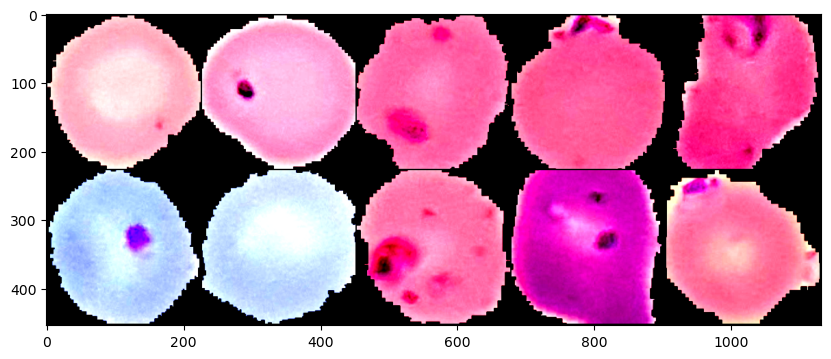

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [8]:
inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                    std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

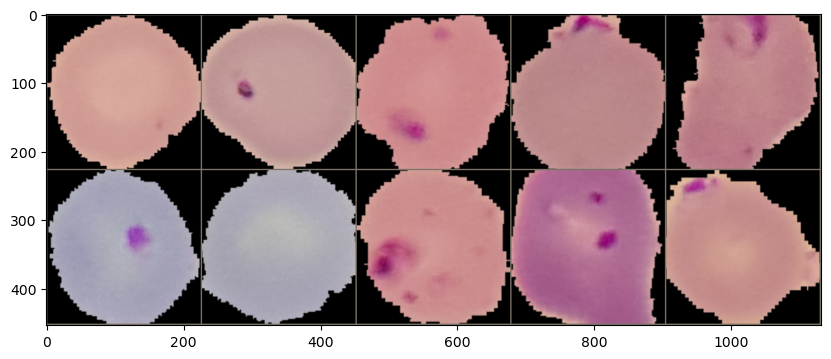

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

# CNN Model

In [10]:
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,6,3,1)
        self.conv2=nn.Conv2d(6,16,3,1)
        self.fc1=nn.Linear(16*54*54,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,20)
        self.fc4=nn.Linear(20,2)
        
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,16*54*54)
        X=F.relu(self.fc1(X))
        X=F.relu(self.fc2(X))
        X=F.relu(self.fc3(X))
        X=self.fc4(X)
        X=F.log_softmax(X,dim=1)
        return X

In [11]:
mycnn=MyCNN()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(mycnn.parameters(),lr=0.001)

In [12]:
mycnn

MyCNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=2, bias=True)
)

In [13]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')
count_parameters(mycnn)

     162
       6
     864
      16
 5598720
     120
   10080
      84
    1680
      20
      40
       2
________
 5611794


In [14]:
import time
start_time=time.time()
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]
epochs=10

for i in range(epochs):
    trn_corr=0
    tst_corr=0
    for b, (X_train,y_train) in enumerate(train_loader):
        b+=1                                            
        y_pred=mycnn(X_train)
        loss=criterion(y_pred,y_train)
        #true predictions
        predicted=torch.max(y_pred.data,1)[1]
        batch_corr=(predicted==y_train).sum()
        trn_corr+=batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200==0:
            print(f"epoch: {i} loss: {loss.item} batch: {b} accuracy: {trn_corr.item()*100/(10*b):7.3f}%")
    loss=loss.detach().numpy()
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    
    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            y_val=mycnn(X_test)
            loss=criterion(y_val,y_test)
            
            predicted=torch.max(y_val.data,1)[1]
            btach_corr=(predicted==y_test).sum()
            tst_corr+=btach_corr
            
        loss=loss.detach().numpy()
        test_losses.append(loss)
        test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds')    

epoch: 0 loss: <built-in method item of Tensor object at 0x7fedf82bee30> batch: 200 accuracy:  65.550%
epoch: 0 loss: <built-in method item of Tensor object at 0x7fedf6755530> batch: 400 accuracy:  75.200%
epoch: 0 loss: <built-in method item of Tensor object at 0x7fedf82bee30> batch: 600 accuracy:  80.400%
epoch: 0 loss: <built-in method item of Tensor object at 0x7fedf6755530> batch: 800 accuracy:  82.662%
epoch: 0 loss: <built-in method item of Tensor object at 0x7fedf82bee30> batch: 1000 accuracy:  84.590%
epoch: 0 loss: <built-in method item of Tensor object at 0x7fedf6755530> batch: 1200 accuracy:  85.733%
epoch: 0 loss: <built-in method item of Tensor object at 0x7fedf82bee30> batch: 1400 accuracy:  86.614%
epoch: 0 loss: <built-in method item of Tensor object at 0x7fedf6755530> batch: 1600 accuracy:  87.431%
epoch: 0 loss: <built-in method item of Tensor object at 0x7fedf82bee30> batch: 1800 accuracy:  87.889%
epoch: 0 loss: <built-in method item of Tensor object at 0x7fedf6728

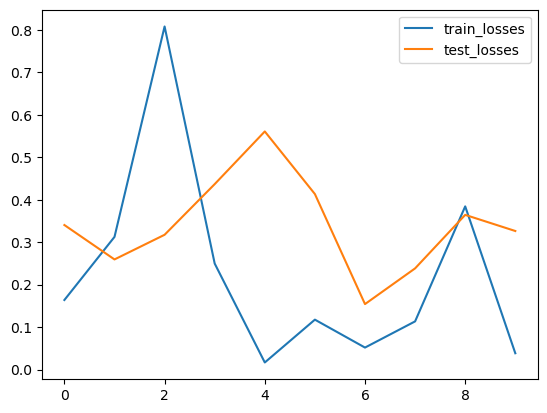

In [15]:
plt.plot(train_losses,label="train_losses")
plt.plot(test_losses,label="test_losses")
plt.legend()

# AlexNetModel

In [16]:
alex= models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [17]:
alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
for param in alex.parameters():
    param.requires_grad=False

In [19]:
torch.manual_seed(42)

alex.classifier=nn.Sequential(nn.Linear(9216,1024),
                                     nn.ReLU(),
                                     nn.Dropout(p=0.5),
                                     nn.Linear(1024,2),
                                     nn.LogSoftmax(dim=1))
alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [20]:
count_parameters(alex)

 9437184
    1024
    2048
       2
________
 9440258


In [21]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(alex.classifier.parameters(),lr=0.001)

In [22]:
import time
start_time=time.time()
train_losses=[]
test_losses=[]
trn_correct=[]
tst_correct=[]

epochs=10
for i in range(epochs):
    trn_corr=0
    tst_corr=0
    for b, (X_train,y_train) in enumerate(train_loader):
        b+=1
        
        y_pred=alex(X_train)
        loss=criterion(y_pred,y_train)       
        #Update parameters
        predicted=torch.max(y_pred.data,1)[1]
        batch_corr=(predicted==y_train).sum()
        trn_corr+= batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%200==0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
    
    loss=loss.detach().numpy()
    train_losses.append(loss)
    train_correct.append(trn_corr)
                  
    with torch.no_grad():
        for b, (X_test,y_test) in enumerate(test_loader):
            b+=1
                  
            y_val=alex(X_test)
            predicted=torch.max(y_val.data,1)[1]
            btach_corr=(predicted==y_test).sum()
            tst_corr+=btach_corr

    loss=criterion(y_val,y_test)
    loss=loss.detach().numpy()
    test_losses.append(loss)
    test_correct.append(tst_corr)
                  
print(f'\nDuration: {time.time() - start_time:.0f} seconds')        

epoch:  0  batch:  200 [  2000/8000]  loss: 0.06947377  accuracy:  82.250%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.13091832  accuracy:  86.500%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.12206466  accuracy:  87.717%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.39683509  accuracy:  88.425%
epoch:  0  batch: 1000 [ 10000/8000]  loss: 0.25564551  accuracy:  88.460%
epoch:  0  batch: 1200 [ 12000/8000]  loss: 0.05017583  accuracy:  88.625%
epoch:  0  batch: 1400 [ 14000/8000]  loss: 0.03878549  accuracy:  88.907%
epoch:  0  batch: 1600 [ 16000/8000]  loss: 0.38302439  accuracy:  88.994%
epoch:  0  batch: 1800 [ 18000/8000]  loss: 0.11273424  accuracy:  89.278%
epoch:  0  batch: 2000 [ 20000/8000]  loss: 0.12912083  accuracy:  89.580%
epoch:  0  batch: 2200 [ 22000/8000]  loss: 0.23911054  accuracy:  89.832%
epoch:  0  batch: 2400 [ 24000/8000]  loss: 0.16020115  accuracy:  90.029%
epoch:  1  batch:  200 [  2000/8000]  loss: 0.04873367  accuracy:  91.500%
epoch:  1  batch:  400 [ 

# Prediction

In [23]:
device = torch.device("cpu")   #"cuda:0"

In [24]:
mycnn.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = mycnn(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
print(y_pred[0:5])

[0, 0, 0, 0, 1]


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

              precision    recall  f1-score   support

 parasitized     0.9596    0.9464    0.9530     12479
  uninfected     0.9471    0.9602    0.9536     12479

    accuracy                         0.9533     24958
   macro avg     0.9534    0.9533    0.9533     24958
weighted avg     0.9534    0.9533    0.9533     24958



In [26]:
alex.eval()
ay_true=[]
ay_pred=[]
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = alex(test_images).argmax(dim=1)
        for i in range(len(pred)):
            ay_true.append(test_labels[i].item())
            ay_pred.append(pred[i].item())
print(ay_pred[0:5])

[0, 0, 0, 0, 1]


In [27]:
from sklearn.metrics import classification_report
print(classification_report(ay_true,ay_pred,target_names=class_names,digits=4))

              precision    recall  f1-score   support

 parasitized     0.9586    0.9442    0.9514     12479
  uninfected     0.9450    0.9592    0.9521     12479

    accuracy                         0.9517     24958
   macro avg     0.9518    0.9517    0.9517     24958
weighted avg     0.9518    0.9517    0.9517     24958

